# Libraries

In [1]:
import tqdm
import spacy
import numpy as np
import regex as re
import pandas as pd
import seaborn as sns

import plotly.graph_objects as go
import plotly.offline as pyo

import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.gensim_models as gensim_models
import pyLDAvis.gensim_models as gensimvis

import gensim
# from gensim.models import wrappers
# from gensim.models.wrappers import LdaMallet
import gensim.corpora as corpora
from gensim.corpora import dictionary
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 


# Think these can be removed
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD

/Users/austinboring/opt/anaconda3/envs/broke-the-other/lib/python3.10/site-packages/gensim/matutils.py:22: DeprecationWarning:

Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.



# Importing -- Fixing columns

In [4]:
full = pd.read_csv('../Data/Data-Cleaned/238k-Uncleaned')

In [5]:
# Renaming tweets column, dropping unnamed column, making tweets strings

full['tweets'] = full['0']
full.reset_index(inplace = True)
full = full.drop(columns = ['0', 'Unnamed: 0', 'index'])
# eh
full.drop_duplicates(inplace = True, ignore_index = True)

# Preprocessing ---- 

In [6]:
# Function for Gensim simple preprocessor --- 
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
# STOPWORDS ==========================================
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words]for doc in texts]
# Stop Words list -- Can be Edited
stop_words = stopwords.words('english')
# stop_words.extend(['tesla', 'c,', 'x', 't', 'p', 'amp', 'car', 'get', 'go', 'use'])
stop_words.extend(['tesla', 'c,', 'x', 't', 'p', 'amp', 'car',
                   'get', 'go', 'use', 'elon', 'musk', 'elon_musk', 'electric', 'vehicle', 'rt'])
wnl = WordNetLemmatizer()

# BIGRAMS===============================================
def make_bigrams(texts):
    return bigram_mod[texts]

# TRIGRAMS =============================================
def make_trigrams(texts):
    return trigram_mod[bigram_mod[texts]]

# LEMMATIZING ==========================================
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None    
def lemmatize_texts(tweet):
     for i in tweet:
        word = (map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(tweet))) 
        word_lem = " ".join([wnl.lemmatize(x[0], x[1]) for x in word if x[1] is not None])
        return word_lem

In [7]:
# remove punctuation and lowercase all
full['preprep'] = full['tweets'].map(lambda x: re.sub('[,\.!?]', '', x.lower()))
#  Removing @ handles, links-- strip whitespace breaks and tabs
full['preprep'] = full['preprep'].map(lambda x: re.sub(r"@\w+|http\S+", "", x).strip()\
                                      .replace("\r", "").replace("\n", "").replace("\t", ""))

In [8]:
# Creates a list of all tweets in full.preprep
data = full.preprep.values.tolist()

# Uses gensims simple preprocessor on all tweets in list
# Ouputs list of lists of tokenized tweets
data_words = list(sent_to_words(data))

In [9]:
# Bigram ---
# higher hyperparameter values =  fewer phrases.
bigram = gensim.models.Phrases(data_words, min_count=2, threshold=20) # orig -- 3/ 75
bigram_mod = gensim.models.phrases.Phraser(bigram)

# TriGrams --
trigram = gensim.models.Phrases(bigram[data_words], threshold=60)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# lemmatize
data_lemmatized = [lemmatize_texts(tweet) for tweet in data_words_bigrams]

In [11]:
print(len(data_words), len(data_lemmatized))

126510 126510


In [12]:
# Getting indices of all nones
indices_of_nones = [(i) for i,x  in enumerate(data_lemmatized) if x == None]
len(indices_of_nones)

386

In [13]:
# Dropping None values using indices aquired above
lem_drop_None = [(i, x) for (i, x) in enumerate(data_lemmatized) if i not in indices_of_nones]
len(lem_drop_None)

126124

In [14]:
# Getting indices of all short tweets
indices_short_tweets = [i for (i,x) in lem_drop_None if (len(x.split(' ')) <= 5)]
len(indices_short_tweets)

38763

In [15]:
lem_noShort_noNone = [(i, x) for (i, x) in lem_drop_None if i not in indices_short_tweets]
len(lem_noShort_noNone)

87361

In [16]:
lem_noNone = [x.split() for (i, x) in lem_noShort_noNone]

In [17]:
id2word = corpora.Dictionary(lem_noNone)
print(len(id2word)) 

62470


In [18]:
# This can be Tuned --- and probably should be
id2word.filter_extremes(no_below=6, no_above=.95)
print(len(id2word))

13580


In [19]:
corpus = [id2word.doc2bow(d) for d in lem_noNone]

## The Rosetta Stone

In [21]:
print(       (lem_noNone[8654]), 
      '\n\n',(lem_noShort_noNone[8654]), 
      '\n\n',(full.preprep.iloc[13394]), 
      '\n\n',(full.tweets.iloc[13394]))

['take', 'forest', 'rather', 'fly', 'hate', 'fucking', 'shuttle', 'bud', 'schedule', 'time'] 

 (13394, 'take forest rather fly hate fucking shuttle bud schedule time') 

 so i can take the tesla to electric forest i’d rather fly but i hate fucking with shuttles and bud schedule times 

 So I can take the Tesla to Electric Forest. I’d rather fly but I hate fucking with shuttles and bud schedule times https://t.co/QRWyFylQmw


# Modeling

In [22]:
# Instantiating a Base LDA model
base_model = LdaMulticore(corpus=corpus,
                          num_topics=5,
                          id2word=id2word,
                          workers=7,
                          passes=5,
                          chunksize=2000,
                          random_state = 42)
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]
topics = [' '.join(t[0:10]) for t in words]

for id, t in enumerate(topics): 
    print(f"------ Topic {id + 1} ------")
    print(t, end="\n\n")

------ Topic 1 ------
car make company world good esg say thing fire people

------ Topic 2 ------
car know find drive door people open free model driver

------ Topic 3 ------
people make ev say company think work want drive car

------ Topic 4 ------
stock buy twitter market sell go price think share make

------ Topic 5 ------
car charge spot buy need battery motor world ev state



In [23]:
# a measure of how good the model is. lower the better
base_perplexity = base_model.log_perplexity(corpus)

# Compute Coherence Score
coherence_model = CoherenceModel(model=base_model, texts=lem_noNone, 
                                   dictionary=id2word, coherence='c_v')

coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base, '\n\nPerplexity: ', base_perplexity)


Coherence Score:  0.27430017888224756 

Perplexity:  -7.904458508315505


In [45]:
newer_model = LdaMulticore(corpus=corpus,
                          num_topics=5,
                          id2word=id2word,
                          workers=4,
                          passes=20,
                          alpha = 0.909 , 
                          eta = 0.01,
                          chunksize=1500,
                          random_state = 100)
newer_words = [re.findall(r'"([^"]*)"',t[1]) for t in newer_model.print_topics()]
newer_topics = [' '.join(t[0:20]) for t in newer_words]

for id, t in enumerate(newer_topics): 
    print(f"------ Topic {id + 1} ------")
    print(t, end="\n\n")

------ Topic 1 ------
stock twitter sell market price buy money back tsla company

------ Topic 2 ------
make people good say think company see thing know battery

------ Topic 3 ------
get find first spacex free spot start call someone crash

------ Topic 4 ------
car buy ev want model new year right make many

------ Topic 5 ------
car need drive world time know charge vehicle also open



In [46]:
# a measure of how good the model is. lower the better
new_perplexity = newer_model.log_perplexity(corpus)

# Compute Coherence Score
coherence_model = CoherenceModel(model=newer_model, texts=lem_noNone, 
                                   dictionary=id2word, coherence='c_v')

coherence_lda_model_new = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_new, '\n\nPerplexity: ', new_perplexity)


Coherence Score:  0.33263773645908434 

Perplexity:  -11.323492886278286


In [47]:
pyLDAvis.enable_notebook()
gensimvis.prepare(newer_model, corpus, id2word)

/Users/austinboring/opt/anaconda3/envs/broke-the-other/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/austinboring/opt/anaconda3/envs/broke-the-other/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/austinboring/opt/anaconda3/envs/broke-the-other/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/austinboring/opt/anaconda3/envs/broke-the-other/lib/python3.10/site-packages/past/builtins/misc.py:

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.049428 -0.011521       1        1  22.507727
3      0.138499 -0.026758       2        1  20.991296
0      0.098774  0.317001       3        1  20.441036
4      0.125340 -0.264023       4        1  19.639188
2     -0.412041 -0.014699       5        1  16.420753, topic_info=          Term          Freq         Total Category  logprob  loglift
116      stock  13362.000000  13362.000000  Default  30.0000  30.0000
88         car  13115.000000  13115.000000  Default  29.0000  29.0000
109        buy  11392.000000  11392.000000  Default  28.0000  28.0000
119    twitter   5250.000000   5250.000000  Default  27.0000  27.0000
54         get   4438.000000   4438.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
1016      case    785.210878    888.755707   Topic5  -5.4009   1.6828
399        man    860.172583   1388.434165   Topic5  -5.3097   1.3278
206        say   1208.809724   6408.658865   Topic5  -4.9694   0.1386
63        work    924.784922   3415.997872   Topic5  -5.2372   0.5000
1181  elonmusk    799.856903   1308.043642   Topic5  -5.3824   1.3148

[321 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1472      4  1.000177  accident
343       1  0.959046  actually
343       2  0.004928  actually
343       3  0.002464  actually
343       4  0.033262  actually
...     ...       ...       ...
290       1  0.158312      year
290       2  0.675548      year
290       3  0.088803      year
290       4  0.077177      year
290       5  0.000495      year

[548 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 5, 3])

In [48]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)



In [49]:
# Every Tweet Classified by Dominant Topic
df_topic_sents_keywords = format_topics_sentences(ldamodel = newer_model,
                                                  corpus = corpus,
                                                  texts = lem_noNone)

In [50]:
sent_topics_Sorteddf = pd.DataFrame()
sent_topics_Outdf = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, group in sent_topics_Outdf:
    sent_topics_Sorteddf = pd.concat([sent_topics_Sorteddf, 
                                             group.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)
# Reset Index    
sent_topics_Sorteddf.reset_index(drop=True, inplace=True)
# Format
sent_topics_Sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]



In [51]:
sent_topics_Sorteddf

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.8408,"stock, twitter, sell, market, price, buy, mone...","[tsla, almost, wednesday, company, remove, esg..."
1,1,0.8012,"make, people, good, say, think, company, see, ...","[bullshit, hahahaha, know, battery, make, envi..."
2,2,0.7709,"get, find, first, spacex, free, spot, start, c...","[dead, smash, construction_equipment, smash, c..."
3,3,0.8496,"car, buy, ev, want, model, new, year, right, m...","[shift, ev, car, decrease, demand, gas, increa..."
4,4,0.8194,"car, need, drive, world, time, know, charge, v...","[ride, road, bike, typically, roads, faster, r..."


In [52]:
def original_tweet_sentiment(cleaned_to_index, original, cleaned_to_topic):
    comp_dic = {}
    sia = SentimentIntensityAnalyzer()
    
    for i in range(len(cleaned_to_index)):
        ind = cleaned_to_index[i][0]
        tweet = original.iloc[ind]
        comp_dic[i] = tweet, sia.polarity_scores(tweet)['compound']
        
    comp_scores = pd.DataFrame(comp_dic).T
    comp_scores.columns = ['Original_tweet', 'Sentiment']
    
    df_sent = cleaned_to_topic.merge(comp_scores, left_index = True, right_index = True)
    
    return df_sent

In [53]:
df_sent = original_tweet_sentiment(lem_noShort_noNone, full['tweets'],df_topic_sents_keywords )
df_sent.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,0,Original_tweet,Sentiment
0,4,0.4418,"car, need, drive, world, time, know, charge, v...","[solar, grid, run, computer, radio, fridge, en...",@testcranker @ITGuy1959 My solar is 100% off g...,0.0
1,1,0.3492,"make, people, good, say, think, company, see, ...","[never, survive, carbon_offsets, implement, de...",@dinodlz @cmclymer Tesla never would have surv...,-0.0777
2,1,0.3627,"make, people, good, say, think, company, see, ...","[right, nonsense, position, find, sort, hard, ...",@RiceAndrew Right - it's just his nonsense pos...,0.3832
3,0,0.4048,"stock, twitter, sell, market, price, buy, mone...","[ford, pe, ration, pe_ratio, tsla, still, long...",@H0NIS0IT @patricklarkin @SRuhle Ford PE ratio...,0.0
4,2,0.2804,"get, find, first, spacex, free, spot, start, c...","[think, back, time, work, employee, brag, work...",Thinking back to that time I worked at Tesla a...,0.5859


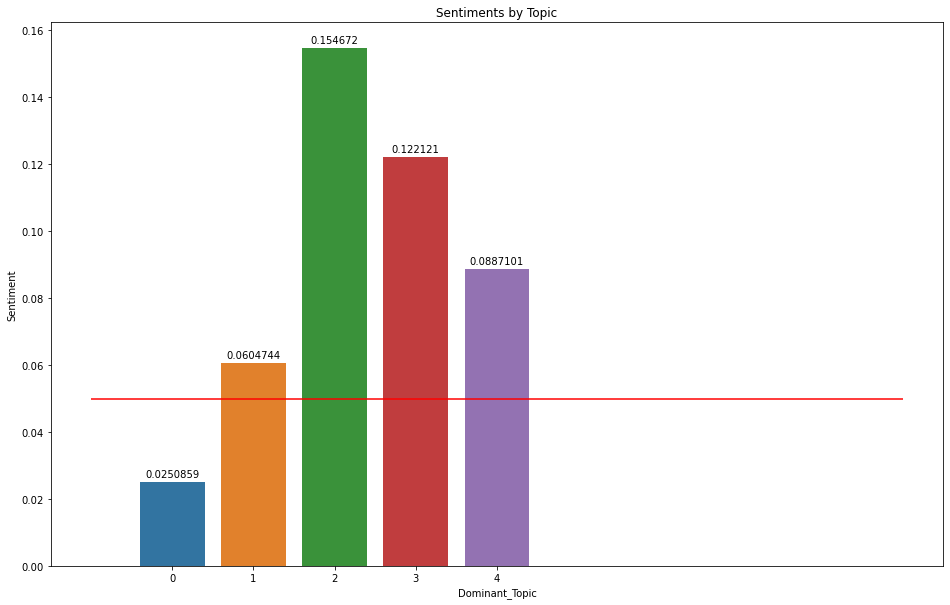

In [57]:
grp_sent = df_sent.Sentiment.groupby(by = df_sent['Dominant_Topic']).mean()

fix, ax = plt.subplots(figsize = (16, 10))
ax = sns.barplot(x = grp_sent.index, y = grp_sent)
ax.bar_label(ax.containers[0], padding = 3)
ax.set_title('Sentiments by Topic')
ax.hlines(y = 0.05, xmin = -1, xmax = 9, colors = 'red')
# ax.bar(grp_sent.index, height = grp_sent)

In [55]:
# Delete this cell 
df_sent['Dominant_Topic'].value_counts(normalize = True)

1    0.240245
0    0.228225
3    0.218484
4    0.183514
2    0.129531
Name: Dominant_Topic, dtype: float64

(array([12413.,     0.,     0.,  2900.,     0.,  9446.]),
 array([0.        , 0.33333333, 0.66666667, 1.        , 1.33333333,
        1.66666667, 2.        ]),
 <BarContainer object of 6 artists>)

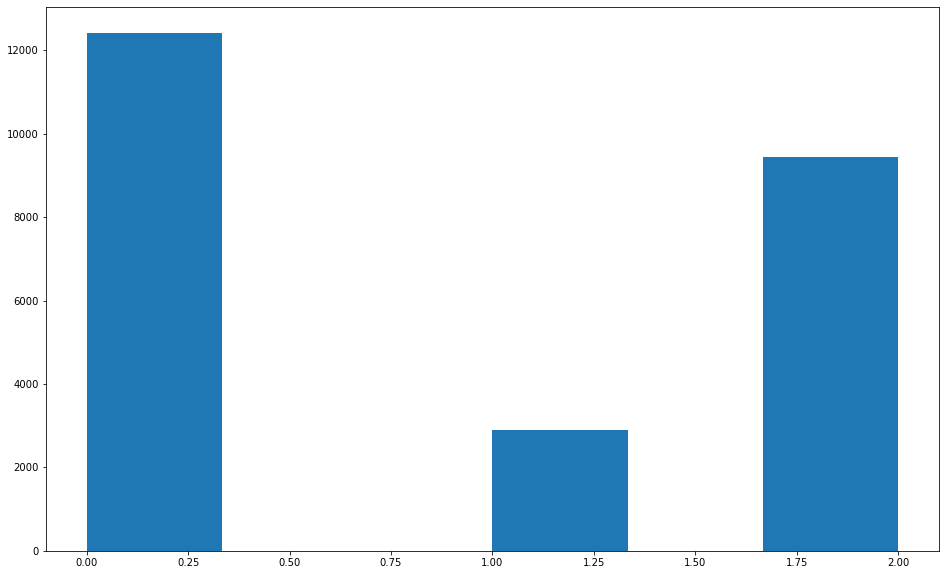

In [72]:
# Topic Distributions VISUALIZATION
topic_dist = pd.Series(df_topic_sents_keywords.Dominant_Topic, dtype = 'category')
# sns.countplot(topic_dist)
fix, ax = plt.subplots(figsize = (16, 10))
plt.hist(topic_dist, bins = 6)

In [372]:
topic_dist

0        4
1        7
2        5
3        6
4        2
        ..
87603    6
87604    3
87605    2
87606    1
87607    2
Name: Dominant_Topic, Length: 87608, dtype: category
Categories (8, int64): [0, 1, 2, 3, 4, 5, 6, 7]

#### ============================================================================

# Below is the grid search the chunky one

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=1500,
                                           passes=8,
                                           alpha=a,
                                           eta=b, 
                                           workers = 7)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=lem_noNone, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 3
max_topics = 9
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [#gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.5)), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['50% Corpus', '75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    results_df = pd.DataFrame(model_results)
    pbar.close()

In [33]:
results_df = pd.read_csv('Data/first-gs-results-24h')
results_df.drop(columns = 'Unnamed: 0', inplace = True)

In [34]:
results_df[(results_df['Coherence'] >= 0.38) & (results_df['Topics'] == 5 )]

,Validation_Set,Topics,Alpha,Beta,Coherence
240,75% Corpus,5,0.01,0.01,0.384454
245,75% Corpus,5,0.31,0.01,0.381647
260,75% Corpus,5,symmetric,0.01,0.380380
420,100% Corpus,5,0.01,0.01,0.381210
430,100% Corpus,5,0.61,0.01,0.384243
440,100% Corpus,5,symmetric,0.01,0.389232


# =============================================================================

In [272]:
results_df.Validation_Set.value_counts()

50% Corpus     180
75% Corpus     180
100% Corpus    180
Name: Validation_Set, dtype: int64

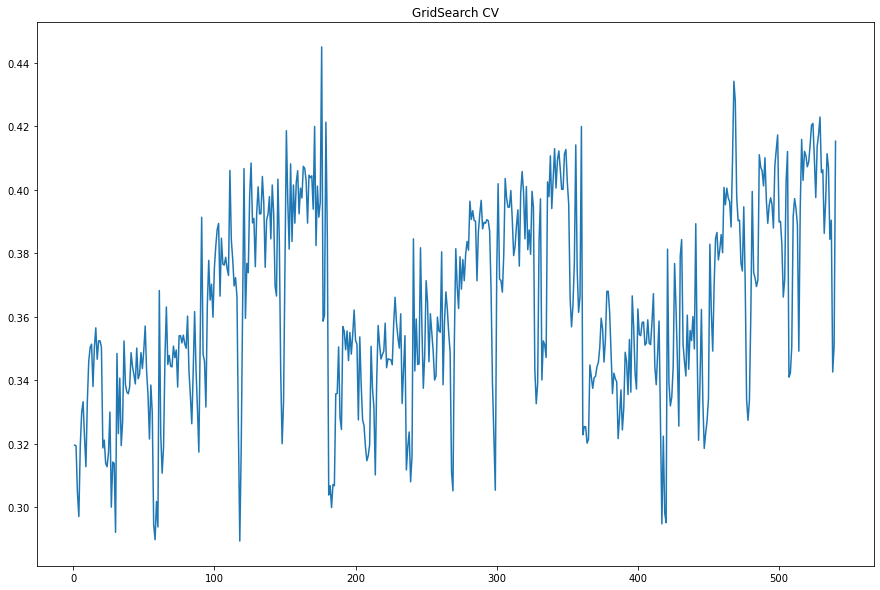

In [351]:
# sns.lineplot(x= range(len(results_df['Coherence'])), y = results_df['Coherence'])

fig, ax = plt.subplots(figsize = (15, 10))
ax.plot(np.linspace(1, 540, 540),'Coherence', data = results_df )
ax.set_title('GridSearch CV');

In [323]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Topics')

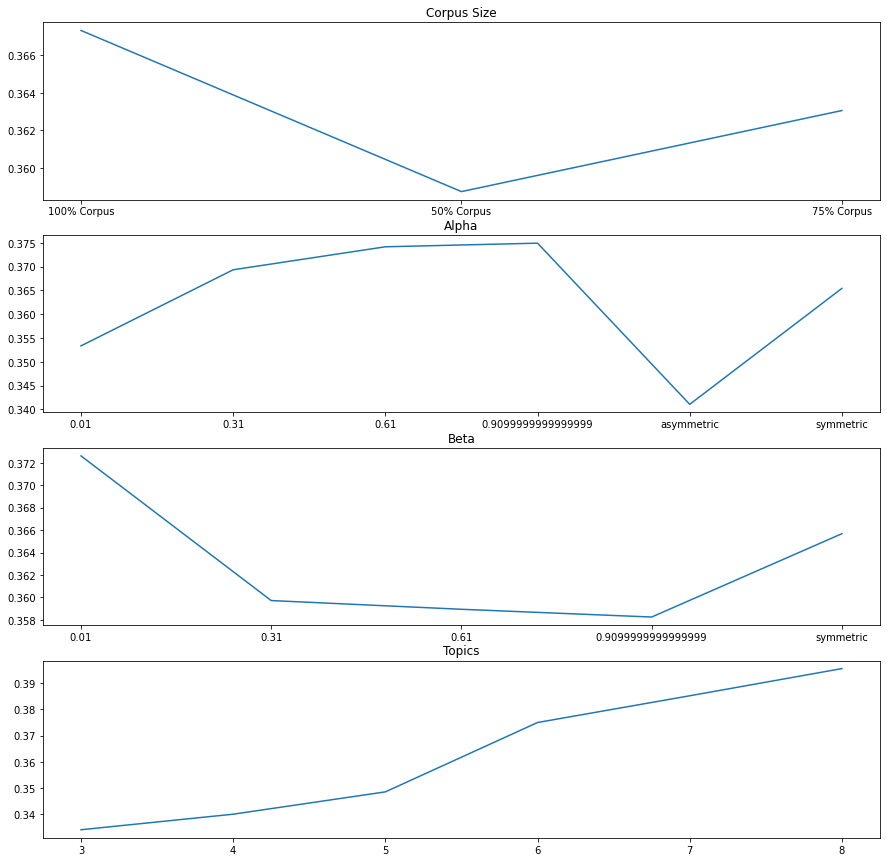

In [335]:

ax1_df = results_df.Coherence.groupby(by=results_df['Validation_Set']).mean()
ax2_df = results_df.Coherence.groupby(by=results_df['Alpha']).mean()
ax3_df = results_df.Coherence.groupby(by=results_df['Beta']).mean()
ax4_df = results_df.Coherence.groupby(by=results_df['Topics']).mean()


fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1 , figsize = (15, 15))




ax1.plot(ax1_df)
ax1.set_title('Corpus Size')

ax2.plot(ax2_df)
ax2.set_title('Alpha')

ax3.plot(ax3_df)
ax3.set_title('Beta')

ax4.plot(ax4_df)
ax4.set_title('Topics')